In [1]:
import os
import math
from os.path import join
import numpy as np
import cv2
import matplotlib.pyplot as plt
from random import randint
import seaborn as sns
import imutils

In [2]:
file = join('input', 'puzzle.png')

In [3]:
np.seterr('raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

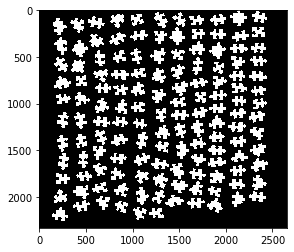

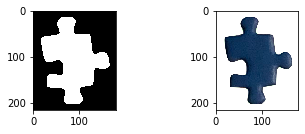

In [4]:
# Read image
img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
ret, img = cv2.threshold(img, 254, 255, cv2.THRESH_BINARY_INV)

plt.figure()
plt.imshow(img,  cmap='gray', vmin=0, vmax=255)
plt.show()


# Show result
subset = img[70:285, 130:310]

fig = plt.figure()
fig.add_subplot(221)
plt.imshow(subset,  cmap='gray', vmin=0, vmax=255)

# Match with original

fig.add_subplot(222)
original = cv2.imread(file)
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
originalSubset = original[70:285, 130:310]


plt.imshow(originalSubset,  cmap='gray', vmin=0, vmax=255)
plt.show()


In [5]:
# Extraction
img_bw, contours, hier = cv2.findContours(
    img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)
print(('Found nb pieces: ' + str(len(contours))))


Found nb pieces: 136


In [6]:
# Define classes


class Piece:

    def __init__(self, id):
        self.id = id
        self.sides = []
        self.p1 = None
        self.p2 = None
        self.p3 = None
        self.p4 = None
        self.sides = {}

    def absP1(self):
        return tuple(np.int32(self.p1 + self.offset[0]))
    def absP2(self):
        return tuple(np.int32(self.p2 + self.offset[0]))
    def absP3(self):
        return tuple(np.int32(self.p3 + self.offset[0]))
    def absP4(self):
        return tuple(np.int32(self.p4 + self.offset[0]))


    def addSide(self, side):
        self.sides.append(side)
        
    def match(self, p):
        print(p)
                
        
    def __repr__(self):
        return "Piece(id={})".format(self.id)

In [35]:
# Utility functions


def angle_between(v1, v2):

    dot_pr = v1.dot(v2)
    norms = np.linalg.norm(v1) * np.linalg.norm(v2)
    return np.rad2deg(np.arccos(dot_pr / norms))


def angle2(v1,v2):
    dot = v1[0]*v2[0] + v1[1]*v2[1]
    det = v1[0]*v2[1] - v1[1]*v2[0]
    return math.degrees(math.atan2(det, dot))

def cart2pol(x, y):
    theta = np.arctan2(y, x)
    rho = np.hypot(x, y)
    return theta, rho


def pol2cart(theta, rho):
    x = rho * np.cos(theta)
    y = rho * np.sin(theta)
    return x, y

def rotate_contour(cnt, angle, pivot):

    cnt_norm = cnt - pivot    
    coordinates = cnt_norm[:, 0, :]
    
    xs, ys = coordinates[:, 0], coordinates[:, 1]
    thetas, rhos = cart2pol(xs, ys)
    
    thetas = np.rad2deg(thetas)
    thetas = (thetas + angle) % 360
    thetas = np.deg2rad(thetas)
    
    xs, ys = pol2cart(thetas, rhos)
    
    cnt_norm[:, 0, 0] = xs
    cnt_norm[:, 0, 1] = ys

    cnt_rotated = cnt_norm + pivot
    cnt_rotated = cnt_rotated.astype(np.int32)

    return cnt_rotated

Piece 10 --------------------------


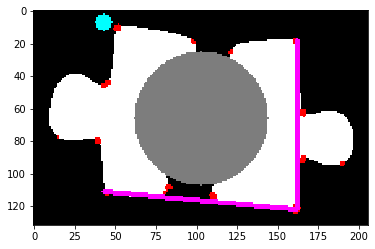

Piece 10 --------------------------
Distance to target 0.0
Fingerpring: 228.5


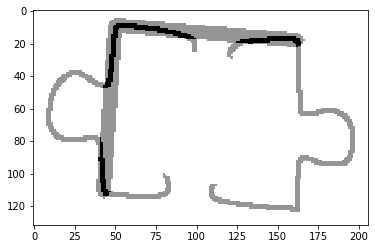

In [50]:
def extract_shape(id, source, cnt, debug=False):

    piece = Piece(id)
    piece.contour = cnt
    

    # crop contour area + 10px frame
    xy_min = offset = cnt.min(axis=0) - 10
    xy_max = cnt.max(axis=0)
    width, height = xy_max[0] - xy_min[0] + 10
    cnt = cnt - offset
    piece.offset = offset
    piece.contour = cnt

    if debug:
        print("Piece {} --------------------------".format(id))

    if debug == 'step_1':
        print(
            'Create a new image with dimentions: ({},{})'.format(width, height)
        )

    frame = np.zeros((height, width), np.uint8)
    cv2.fillPoly(frame, pts=[cnt], color=(255, 255, 255))

    dst = cv2.cornerHarris(frame, 5, 3, 0.04)
    ret, dst = cv2.threshold(dst, 0.1*dst.max(), 255, 0)
    dst = np.uint8(dst)
    ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
    corners = cv2.cornerSubPix(frame, np.float32(
        centroids), (5, 5), (-1, -1), criteria)
    # Define center zone to avoid (obviously no corner there)

    center = np.flip(np.int32(np.array(frame.shape)/2))
    center_radius = int(max(width, height) * 0.20)

    min_length = int(min(width, height) * 0.45)
    angle_delta = 8

    if debug:
        frameview = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
        frameview[dst > 0.1*dst.max()] = [255, 0, 0]
        cv2.circle(frameview, tuple(center),
                   center_radius, (125, 125, 125), -1)


    border_mask = cv2.Canny(frame, 100, 200)
    kernel = np.ones((3, 3), np.uint8)
    border_mask = cv2.dilate(border_mask, kernel)
    
    if debug == 'step_3':
        print("Min side length: {}".format(min_length))
        cv2.circle(frameview, tuple(center),
        center_radius, (125, 125, 125), -1)
        plt.figure()
        plt.imshow(frameview)
        plt.show()

    if debug == 'step_4':
        plt.figure()
        plt.imshow(border_mask, cmap='gray')
        plt.show()

    mean_hashes = []
    best_fingerprint = 0
    best_mask = None

    for p1 in corners:

        # x,y = p1
        # if int(x) == 99 and int(y) == 21:
        #    print('found')
        #    debug='step_3"
        # else:
        #    debug=False

        if np.linalg.norm(p1 - center) < center_radius:
            continue

        if debug == 'step_3.1':
            fv2 = frameview.copy()
            fv2 = cv2.circle(fv2, tuple(p1), 5, (0, 255, 0), -1)
            plt.figure()
            plt.imshow(fv2)
            plt.show()

        for p2 in corners:

            # x,y = p2
            # if int(x) == 156 and int(y) == 64:
            #    print('found')
            # else:
            #    continue

            if np.linalg.norm(p2 - center) < center_radius \
                    or np.linalg.norm(p2 - p1) < min_length:
                continue

            if debug == 'step_3.1':
                cv2.circle(fv2, tuple(p2), 5, (255, 255, 0), -1)
                plt.figure()
                plt.imshow(fv2)
                plt.show()
                print(p2)

            for p3 in corners:

                if np.linalg.norm(p3 - center) < center_radius \
                        or np.linalg.norm(p3-p1) < min_length \
                        or np.linalg.norm(p3-p2) < min_length:
                    continue

                # Deduplicate
                mean_hash = str(p1) + str(np.array([p1, p2, p3]).mean())
                if (mean_hash in mean_hashes):
                    if debug:
                        # print("duplicate found")
                        pass
                    continue
                mean_hashes.append(mean_hash)

                if debug == 'step_3.1':
                    cv2.circle(fv2, tuple(p3), 5, (0, 255, 255), -1)
                    plt.figure()
                    plt.imshow(fv2)
                    plt.show()

                v1 = p2-p1
                v2 = p3-p1
                angle = angle_between(v1, v2)

                if (angle > 90 + angle_delta or angle < 90 - angle_delta):
                    continue

                if debug == 'step_3':
                    print(
                        """Points:
  p1 (green): {},
  p2 (yellow) {},
  p3 (cyan) {}""".format(p1, p2, p3)
                    )
                    print("p1-p2: {}".format(np.linalg.norm(p2 - p1)))
                    print("p1-p3: {}".format(np.linalg.norm(p3 - p1)))
                    print("p2-p3: {}".format(np.linalg.norm(p2 - p3)))
                    print("Angle: {}".format(abs(angle)))

                    frameviewpoints = frameview.copy()
                    cv2.circle(frameviewpoints, tuple(p1), 5, (0, 255, 0), -1)
                    cv2.circle(frameviewpoints, tuple(
                        p2), 5, (255, 255, 0), -1)
                    cv2.circle(frameviewpoints, tuple(
                        p3), 5, (0, 255, 255), -1)
                    cv2.line(frameviewpoints, tuple(p1),
                             tuple(p1+v1), (255, 0, 255), 2)
                    cv2.line(frameviewpoints, tuple(p1),
                             tuple(p1+v2), (255, 0, 255), 2)

                    plt.figure()
                    plt.imshow(frameviewpoints)
                    plt.show()

                # Step 4:  mask base comparison

                mask = np.zeros((height, width), np.uint8)
                cv2.line(mask, tuple(p1), tuple(p1+v1), (255, 255, 255), 7)
                cv2.line(mask, tuple(p1), tuple(p1+v2), (255, 255, 255), 7)
                mask = cv2.addWeighted(border_mask, 0.5, mask, 0.5, 0)
                cv2.circle(mask, tuple(center), center_radius, (0, 0, 0), -1)

                fingerprint = len(np.where(mask == 255)[0])

                if debug == 'step_4':
                    print("Fingerpring: {}".format(fingerprint))
                    plt.figure()
                    plt.imshow(mask, cmap='Greys')
                    plt.show()

                # Step 5 keep best fingerprint
                if fingerprint > best_fingerprint:
                    best_fingerprint = fingerprint
                    piece.p1 = p1
                    piece.p2 = p2
                    piece.p4 = p3
                    if debug == 'step_5':
                        best_mask = mask.copy()
    
    if debug == 'step_5':
        print("Best fingerprint: {}".format(best_fingerprint))
        plt.figure()
        plt.imshow(best_mask, cmap='Greys')
        plt.show()     
        
    # Step 6 - target for p4
    
    target = piece.p4 + piece.p2 - piece.p1

    if debug == 'step_6':
        plt.figure()
        frameviewpoints = frameview.copy()
        cv2.line(frameviewpoints, tuple(piece.p1),
                            tuple(piece.p2), (255, 0, 255), 2)
        cv2.line(frameviewpoints, tuple(piece.p1),
                             tuple(piece.p4), (255, 0, 255), 2)
        cv2.circle(frameviewpoints, tuple(target
                    ), 5, (0, 255, 255), -1)
        plt.imshow(frameviewpoints)
        plt.show()
        
    
    # Step 7 - find corners in the target area
    allpoints = []
    for p4 in corners:
        dist = np.linalg.norm(target - p4)
        allpoints.append((dist, p4))
    allpoints = sorted(allpoints, key=lambda value: value[0]) 
    #if debug == 'step_7':
        #print(allpoints)
    
    best_mask = None
    best_fingerprint = 0
    
    # Hack - solve missing detection of 4th corner (not sharp enough)
    allpoints.append((0, target))
    
    for dist, p4 in allpoints:
        dist = np.linalg.norm(target - p4)
        if (dist > min(width,height) * 0.25):
            continue
            
        v1 = piece.p2-p4
        v2 = piece.p4-p4
        angle = angle_between(v1, v2)

        if (angle > 95 + angle_delta or angle < 85 - angle_delta):
            continue
            
            
        mask = np.zeros((height, width), np.uint8)
        cv2.line(mask, tuple(piece.p2), tuple(p4), (255, 255, 255), 7)
        cv2.line(mask, tuple(piece.p4), tuple(p4), (255, 255, 255), 7)
        mask = cv2.addWeighted(border_mask, 0.5, mask, 0.5, 0)
        cv2.circle(mask, tuple(center), center_radius, (0, 0, 0), -1)

        fingerprint = len(np.where(mask == 255)[0])
        if (np.array_equal(p4, target)):
            fingerprint = fingerprint/2
        
        if (fingerprint > best_fingerprint):
            piece.p3 = p4
            piece.mask = frame
            best_fingerprint = fingerprint
            if debug:
                best_mask = mask.copy()
            
        if debug == 'step_7':
            print('Distance to target {}'.format(dist))
            print("Fingerpring: {}".format(fingerprint))
            plt.figure()
            plt.imshow(best_mask, cmap='Greys')
            plt.show()  
            
    if debug == 'step_8':
        print('Distance to target {}'.format(dist))
        print("Fingerpring: {}".format(fingerprint))
        plt.figure()
        plt.imshow(best_mask, cmap='Greys')
        plt.show()  

    return piece


i =10
# pieces = extract_shape(i, img, contours[i], debug = 'step_2')
# pieces = extract_shape(i, img, contours[i], debug = 'step_3')
# pieces = extract_shape(i, img, contours[i], debug = 'step_3.1')
# pieces = extract_shape(i, img, contours[i], debug = 'step_4')
# pieces = extract_shape(i, img, contours[i], debug='step_5')
pieces = extract_shape(i, img, contours[i], debug='step_6')
# pieces = extract_shape(i, img, contours[i], debug='step_7')
pieces = extract_shape(i, img, contours[i], debug='step_8')




Piece 11 --------------------------
Distance to target 0.0
Fingerpring: 212.0


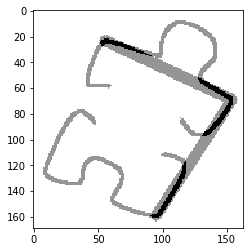

Piece 25 --------------------------
Distance to target 0.0
Fingerpring: 286.0


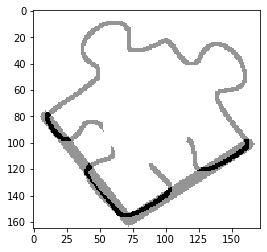

Piece 123 --------------------------
Distance to target 0.0
Fingerpring: 222.5


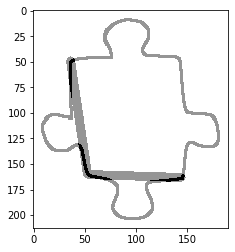

Piece 130 --------------------------
Distance to target 0.0
Fingerpring: 283.5


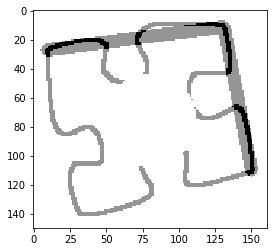

Piece 131 --------------------------
Distance to target 0.0
Fingerpring: 201.0


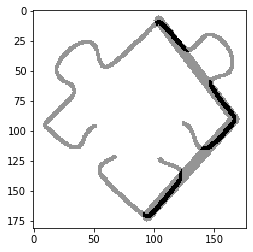

In [51]:
# Debug, complex cases


debug = 'step_8'
#for i in [11, 25, 40, 43, 47, 59, 98, 109, 111, 116, 120, 125]:
for i in [11, 25,123,130,131]:
    shapes = extract_shape(i, img, contours[i], debug)

In [52]:
#for i, piece in enumerate(contours[0:10]):
#    piece = extract_shape(i, img, piece, debug='step_8')

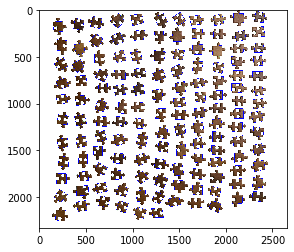

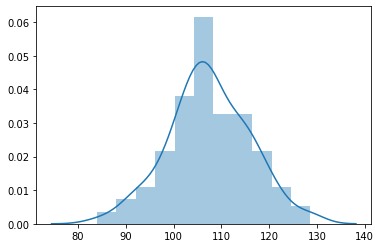

In [53]:
# Export to file

exportimg = cv2.imread(file)
pieces = []
piece_length = []
for i, contour in enumerate(contours):
    piece = extract_shape(i, img, contour, debug=False)
    
    pieces.append(piece)

    piece_length.append(np.linalg.norm(piece.p1 - piece.p2))

    cv2.line(exportimg, piece.absP1(), piece.absP2(), (0, 0, 255), 2)
    cv2.line(exportimg, piece.absP2(), piece.absP3(), (0, 0, 255), 2)
    cv2.line(exportimg, piece.absP3(), piece.absP4(), (0, 0, 255), 2)
    cv2.line(exportimg, piece.absP4(), piece.absP1(), (0, 0, 255), 2)

cv2.imwrite(join('output', 'export.png'), exportimg)

plt.figure()
plt.imshow(exportimg, cmap='Greys')
plt.show()

# Side length distribution
plt.figure()
sns.distplot(piece_length)
plt.show()

Piece 5
Angle: 254.02987532838267


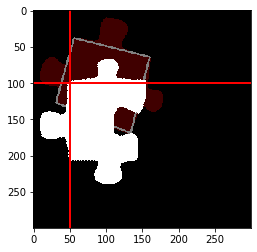

Piece 5
Angle: -105.97012467161734


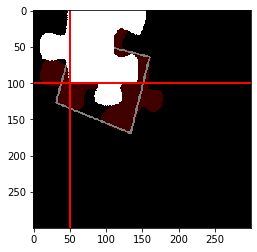

Piece 1
Angle: 179.53843448235864


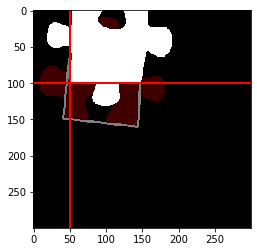

Piece 1
Angle: -95.83456626074351


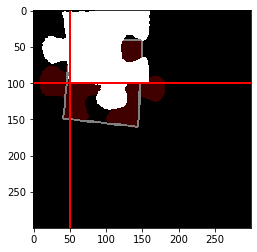

Piece 1
Angle: -6.037830388473329


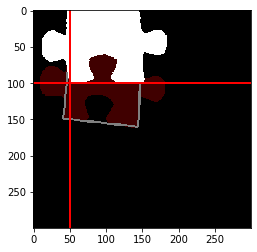

Piece 1
Angle: 86.76326535790248


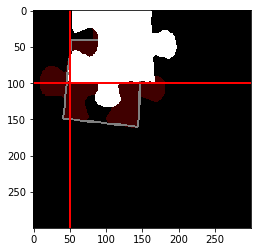

In [54]:
# Create masks to be matched

def create_mask(piece, side, top):
    
    benchpoint =  np.array([50,100])
    horizontal = np.array([100,0])
    contour = np.array([piece.p1, piece.p2, piece.p3, piece.p4])
    width = 100
    M = cv2.moments(contour)
    center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))
    piece.center = center
    
    if side == 0 : #pink side
        p3 = piece.p3
        p2 = piece.p2
        p1 = piece.p1  
    elif side == 1 : #blue side
        p3 = piece.p4
        p2 = piece.p3
        p1 = piece.p2
    elif side == 2 : #gree side
        p3 = piece.p1
        p2 = piece.p4
        p1 = piece.p3
    elif side == 3 : #red side
        p3 = piece.p2
        p2 = piece.p1
        p1 = piece.p4
        
    angle = angle2(p2 - p1, horizontal)
    width = np.linalg.norm(p2 - p1)
    rpoint = p1
    height = np.linalg.norm(p3 - p2)
    
    clockwise = angle2(p1-center, p2-center) > 0
    if (not top):
        angle = angle + 180
        if not clockwise:
            benchpoint = benchpoint + (width,0)
        else:
            benchpoint = benchpoint + (width,height)
    else:
        if clockwise:
            angle = angle - 180
            benchpoint = benchpoint + (width,0)

    mask = np.zeros((300,300,3), np.uint8)

    if (debug == 'step_10'):
        print("Piece {}".format(piece.id))
        print("Angle: {}".format(angle))
        cv2.drawContours(mask, [piece.contour], 0, (64, 0, 0), -1)
        cv2.drawContours(mask,[contour.astype(np.int32)],0,(128,128,128),2)
       
        
    rotated_piece = rotate_contour(piece.contour, angle, rpoint)
    rotated_piece = rotated_piece - rpoint + benchpoint

    cv2.drawContours(mask,[rotated_piece.astype(np.int32)],0,(255,255,255),-1)

    if debug in ('step_10.1', 'step_10'):
        cv2.line(mask, (0,100), (300,100), (255,0,0), 2)
        cv2.line(mask, (50,0), (50,300), (255,0,0), 2)
        
    if debug == 'step_10':
        plt.imshow(mask)
        plt.show() 
        
    return mask

debug = 'step_10'
create_mask(pieces[5], side=0, top=False)
create_mask(pieces[5], side=0, top=True)
create_mask(pieces[1], side=1, top=True)
create_mask(pieces[1], side=2, top=True)
create_mask(pieces[1], side=3, top=True)
create_mask(pieces[1], side=0, top=True)
pass

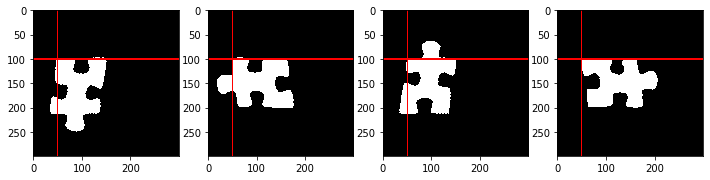

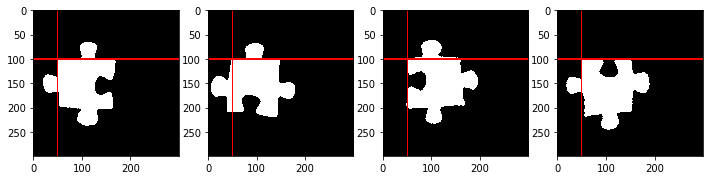

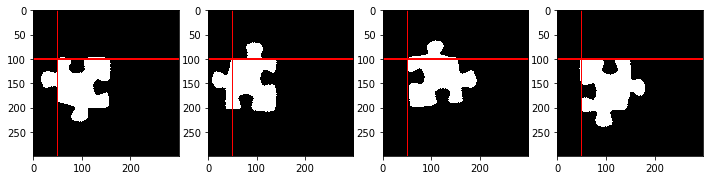

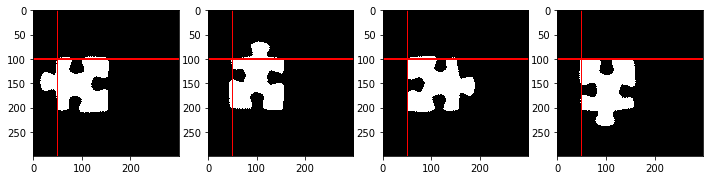

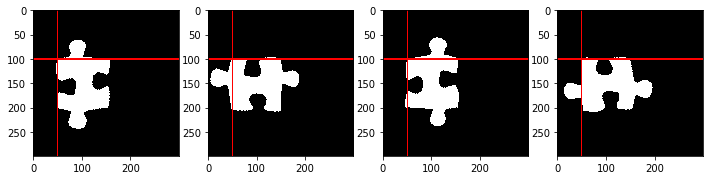

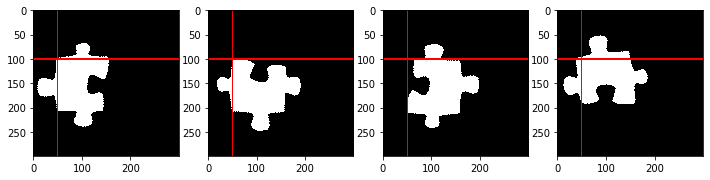

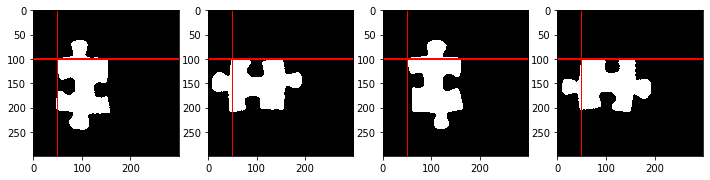

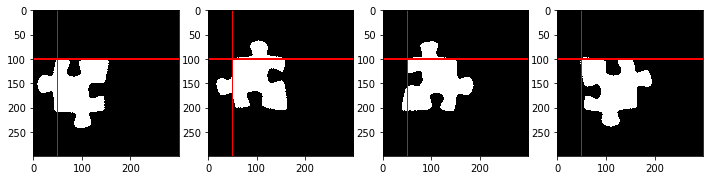

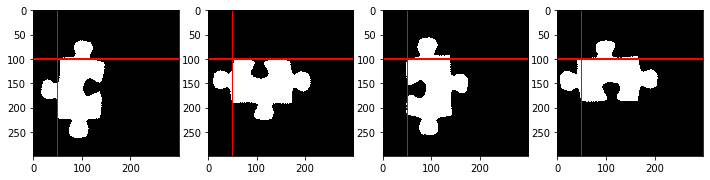

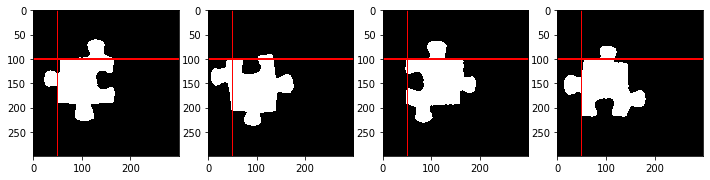

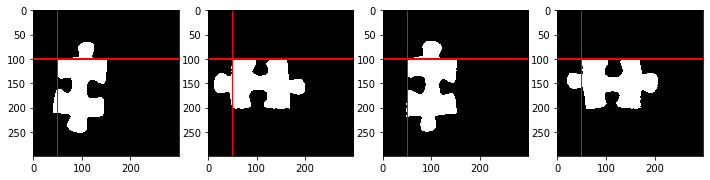

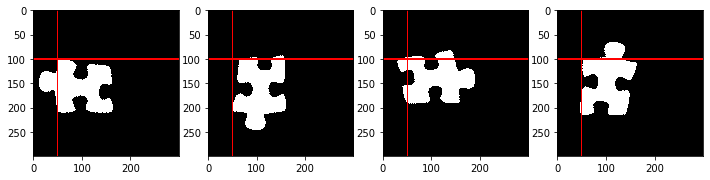

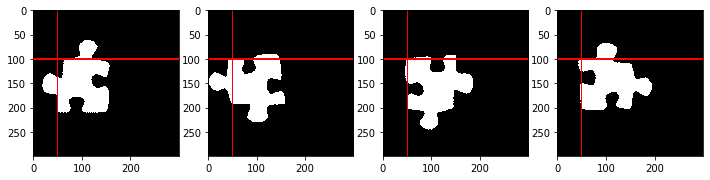

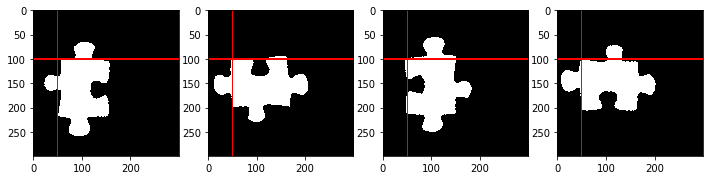

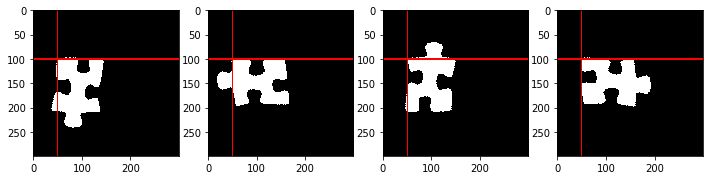

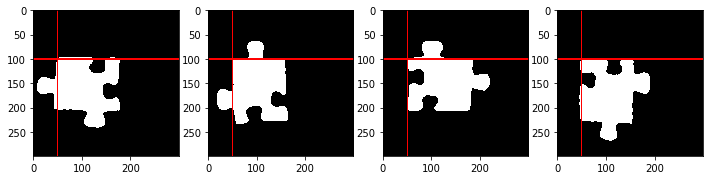

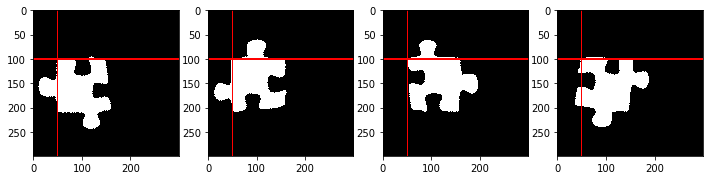

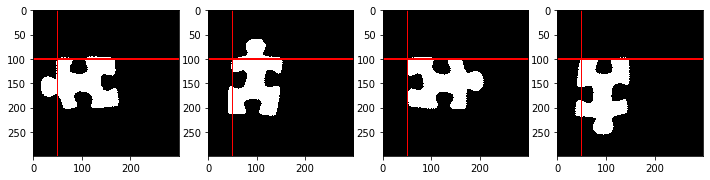

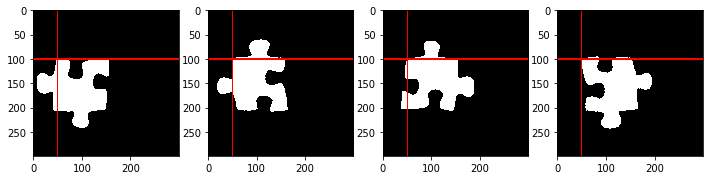

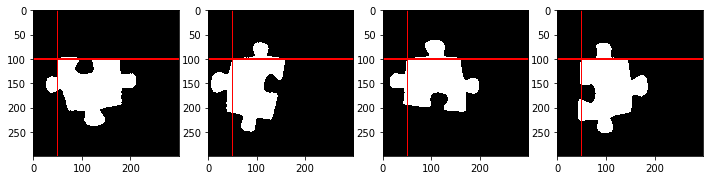

In [55]:
debug = 'step_10.1'
isTop = False
for p in pieces[0:20]:
    fig = plt.figure(figsize=(12,3))
    fig.add_subplot(141)
    plt.imshow(create_mask(p, side=0, top=isTop))
    fig.add_subplot(142)
    plt.imshow(create_mask(p, side=1, top=isTop))
    fig.add_subplot(143)
    plt.imshow(create_mask(p, side=2, top=isTop))
    fig.add_subplot(144)
    plt.imshow(create_mask(p, side=3, top=isTop))
    plt.show()

Pieces set count: 136
Process piece: 0
Process piece: 1
Process piece: 2
Process piece: 3
Process piece: 4
Process piece: 5
Score: 381


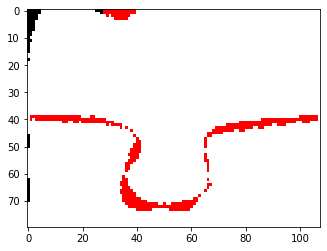

Process piece: 6
Process piece: 7
Process piece: 8
Process piece: 9
Process piece: 10
Process piece: 11
Process piece: 12
Process piece: 13
Process piece: 14
Process piece: 15
Process piece: 16
Process piece: 17
Process piece: 18
Process piece: 19
Process piece: 20
Process piece: 21
Score: 384


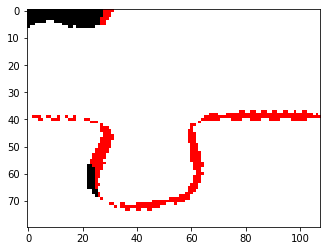

Score: 354


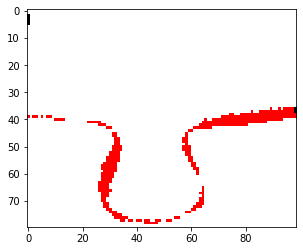

Score: 385


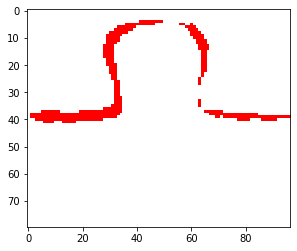

Process piece: 22
Process piece: 23
Process piece: 24
Process piece: 25
Score: 381


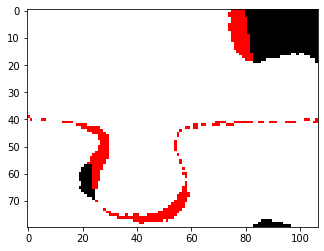

Process piece: 26
Process piece: 27
Process piece: 28
Score: 393


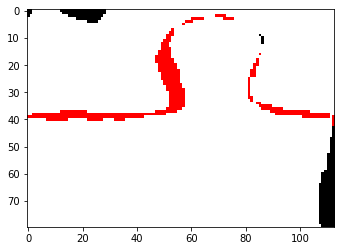

Process piece: 29
Process piece: 30
Process piece: 31
Process piece: 32
Score: 387


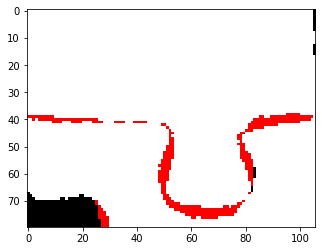

Process piece: 33
Process piece: 34
Process piece: 35
Process piece: 36
Score: 384


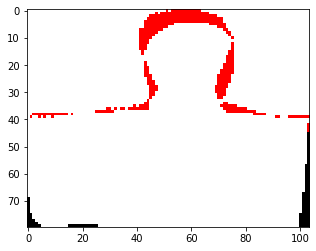

Process piece: 37
Process piece: 38
Process piece: 39
Score: 380


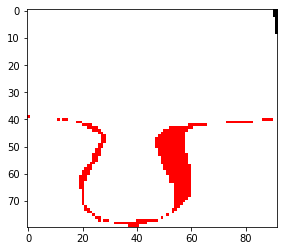

Process piece: 40
Score: 392


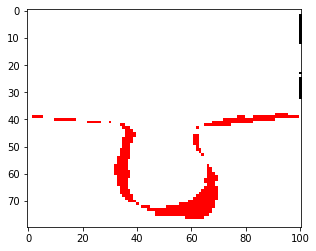

Process piece: 41
Process piece: 42
Process piece: 43
Process piece: 44
Process piece: 45
Process piece: 46
Process piece: 47
Process piece: 48
Process piece: 49
Process piece: 50
Process piece: 51
Process piece: 52
Process piece: 53
Process piece: 54
Process piece: 55
Process piece: 56
Process piece: 57
Process piece: 58
Process piece: 59
Process piece: 60
Process piece: 61
Score: 323


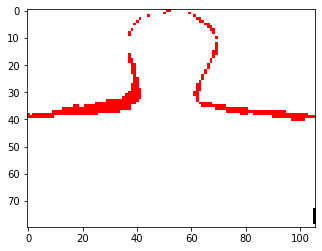

Process piece: 62
Process piece: 63
Score: 307


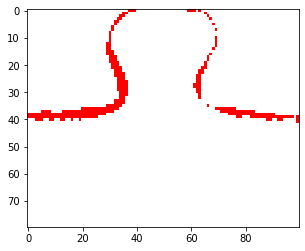

Process piece: 64
Process piece: 65
Score: 354


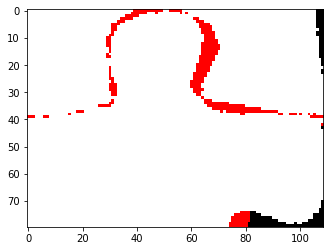

Process piece: 66
Score: 294


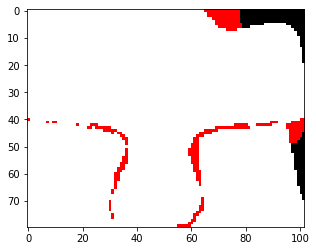

Process piece: 67
Score: 323


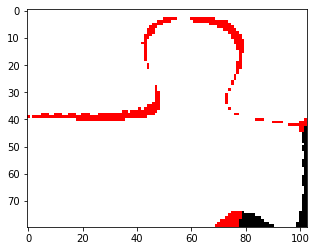

Process piece: 68
Process piece: 69
Score: 393


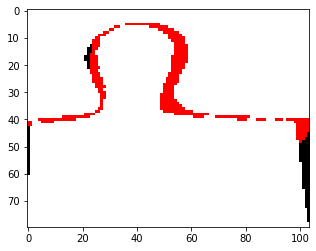

Process piece: 70
Process piece: 71
Process piece: 72
Process piece: 73
Process piece: 74
Process piece: 75
Process piece: 76
Process piece: 77
Process piece: 78
Process piece: 79
Process piece: 80
Score: 395


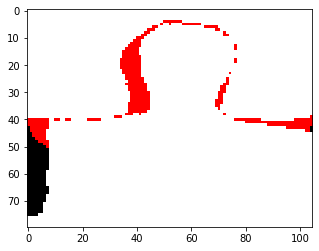

Process piece: 81
Process piece: 82
Score: 387


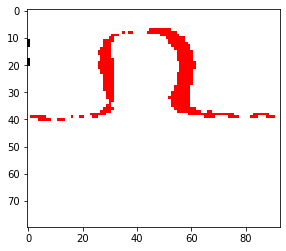

Process piece: 83
Process piece: 84
Process piece: 85
Process piece: 86
Score: 286


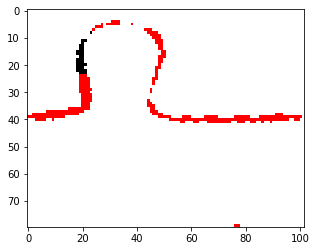

Process piece: 87
Process piece: 88
Score: 202


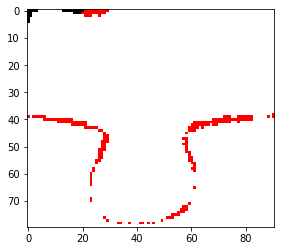

Process piece: 89
Process piece: 90
Score: 264


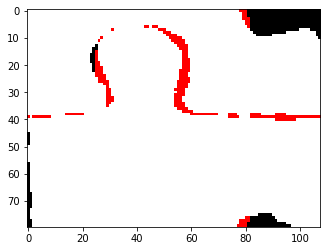

Process piece: 91
Process piece: 92
Score: 375


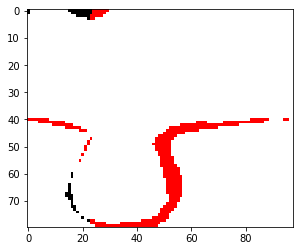

Process piece: 93
Process piece: 94
Process piece: 95
Process piece: 96
Process piece: 97
Process piece: 98
Process piece: 99
Process piece: 100
Process piece: 101
Process piece: 102
Process piece: 103
Process piece: 104
Process piece: 105
Process piece: 106
Process piece: 107
Process piece: 108
Process piece: 109
Score: 298


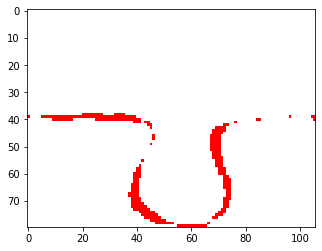

Score: 287


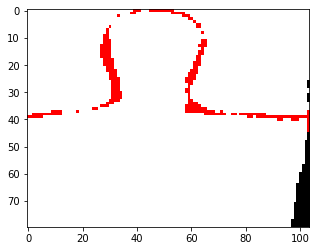

Score: 370


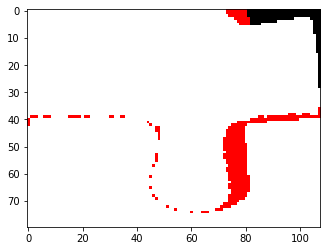

Process piece: 110
Process piece: 111
Process piece: 112
Score: 279


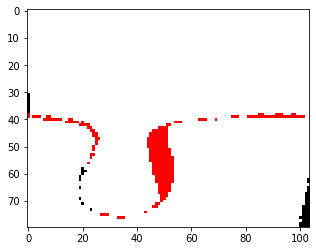

Score: 321


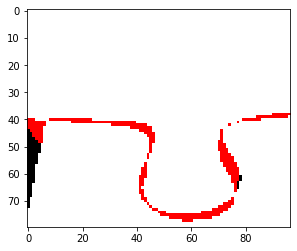

Process piece: 113
Process piece: 114
Process piece: 115
Score: 367


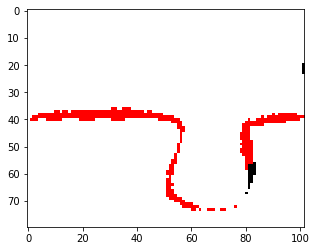

Process piece: 116
Process piece: 117
Score: 258


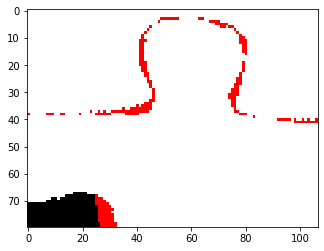

Process piece: 118
Process piece: 119
Process piece: 120
Process piece: 121
Score: 329


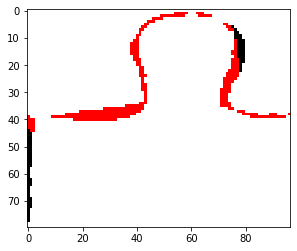

Score: 274


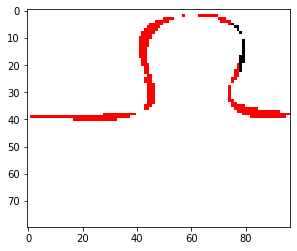

Process piece: 122
Process piece: 123
Process piece: 124
Process piece: 125
Process piece: 126
Process piece: 127
Score: 248


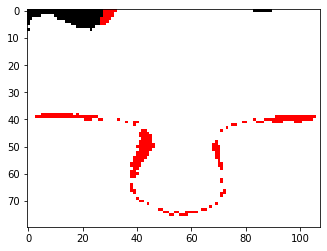

Process piece: 128
Process piece: 129
Process piece: 130
Process piece: 131
Process piece: 132
Process piece: 133
Score: 356


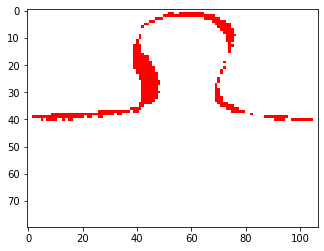

Process piece: 134
Process piece: 135
Score: 331


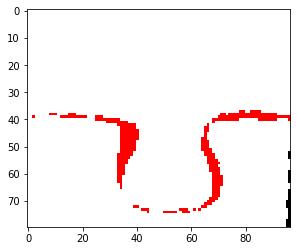

In [56]:
## Brute force match

debug = 'step_11.3'

match_threshold = 0.1
max_pixel = 400

print("Pieces set count: {}".format(len(pieces)))

maskm = np.zeros((300,300,3), np.uint8)

# Generate all masks
for p in pieces:
    p.mask = [
        create_mask(p, side=0, top=True),
        create_mask(p, side=1, top=True),
        create_mask(p, side=2, top=True),
        create_mask(p, side=3, top=True)
    ]
    p.match_mask = [
        create_mask(p, side=0, top=False),
        create_mask(p, side=1, top=False),
        create_mask(p, side=2, top=False),
        create_mask(p, side=3, top=False)
    ]
    p.side_width=[
        np.linalg.norm(p.p2 - p.p1),
        np.linalg.norm(p.p3 - p.p2),
        np.linalg.norm(p.p4 - p.p3),
        np.linalg.norm(p.p4 - p.p1)
    ]

for p1 in pieces:
    if debug:
        print('Process piece: {}'.format(p1.id))
    for p2 in pieces: 
        if p1.id == p2.id:
            continue
        for side_index in range(4):
            for match_side_index in range(4):
                p1_side = p1.side_width[side_index]
                p2_side = p2.side_width[match_side_index]
                if abs(p1_side - p2_side) < match_threshold:
                    
                    if debug == 'step_11.1':
                        print("Match found: #{}.{} with #{}.{} - {:10.4f} {:10.4f}".format(p1.id,side_index,p2.id, match_side_index, p1_side, p2_side))
                        fig = plt.figure()
                        fig.add_subplot(121)
                        plt.imshow(p1.mask[side_index])
                        fig.add_subplot(122)
                        plt.imshow(p2.match_mask[match_side_index])
                        plt.show()
                        
                    redmask = maskm.copy()
                    
                    redmask = cv2.ellipse(redmask, (50+int(p1_side/2),100),(int(p1_side/2),20),0,0,360,255,-1)
                    redmask = cv2.ellipse(redmask, (50+int(p1_side/2),100),(30,int(p1_side*0.75)),0,0,360,255,-1)
                    
                    img = cv2.bitwise_xor(p1.mask[side_index],p2.match_mask[match_side_index])
                    img = cv2.bitwise_or(img, redmask)
                    
    
                    img = img[60:140, 50:int(50+p1_side)]
                    
                    img2 = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
                    reds = cv2.countNonZero(cv2.inRange(img2, np.array([110,50,50]), np.array([130,255,255])))
                    
                    if debug == 'step_11.2':
                        print("Matching:\n  Reds: {}".format(reds))
                        plt.imshow(img)
                        plt.show()
                        
                    if reds < max_pixel:
                        print("Score: {}".format(reds))
                        plt.imshow(img)
                        plt.show()
                        
                        p1.sides[side_index] = (match_side_index, p2)
                        #p2.sides[match_side_index] = p1
                        
                        

True

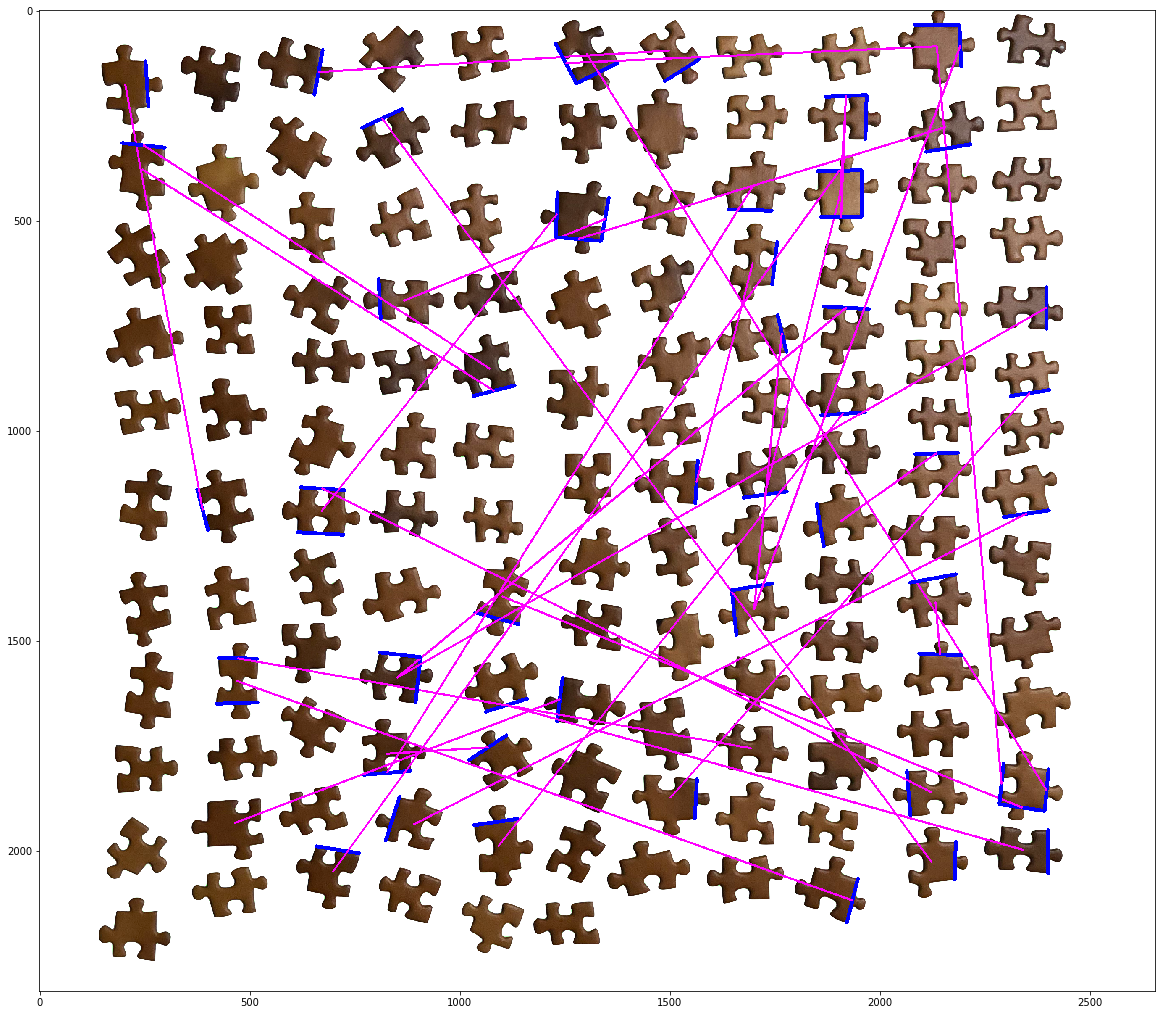

In [66]:
img = cv2.imread(file)#[:,:,::-1]
plt.figure(figsize=(20,20))

for p in pieces:

 
    for s in p.sides:
        (index, target) = p.sides[s]
        
        if s == 0: 
            p1 = p.p1
            p2 = p.p2
        elif s == 1:
            p1 = p.p2
            p2 = p.p3
        elif s == 2:
            p1 = p.p3
            p2 = p.p4
        elif s == 3:
            p1 = p.p4
            p2 = p.p1
            
        if index == 0:
            tp1 = target.p1
            tp2 = target.p2
        elif s == 1:
            tp1 = target.p2
            tp2 = target.p3
        elif s == 2:
            tp1 = target.p3
            tp2 = target.p4
        elif s == 3:
            tp1 = target.p4
            tp2 = target.p1 
            
        toffset = target.offset[0]
        tp1 = toffset + tp1.astype(np.int32)
        tp2 = toffset + tp2.astype(np.int32)
        
        tcenter = (toffset).astype(np.int32)
            
            
        offset = p.offset[0]
        p1 = offset + p1.astype(np.int32)
        p2 = offset + p2.astype(np.int32)
        cv2.line(img,tuple(p1),tuple(p2),(0,0,255),7)
        cv2.line(img,tuple(tp1),tuple(tp2),(0,0,255),7)
        
        center = (p1 + (p2-p1)/2).astype(np.int32)
            
        target_center = target.offset + target.center
        #print(center[0], target_center[0])
        cv2.line(img,tuple(center),tuple(target_center[0]),(255,0,255),4)  
        
  
        
plt.imshow(img,  cmap='gray', vmin=0, vmax=255)
cv2.imwrite(join('output', 'resolved.png'), img)